In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms, models
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [5]:
print(len(training_dataset))
print(len(validation_dataset))

1768
759


In [6]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [7]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

In [8]:
# class CustomModel(nn.Module):
#     def __init__(self, num_classes=6):
#         super(CustomModel, self).__init__()
        
#         # AlexNet-like architecture
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
        
#         # ResNet-like architecture
#         self.residual_block = nn.Sequential(
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#         )
        
#         # Global average pooling
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
#         # Fully connected layers
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(256, 128),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x_residual = self.residual_block(x)
#         x = x + x_residual
#         x = self.avgpool(x)
#         x = self.fc(x)
#         return x

In [9]:
# class CustomModel(nn.Module):
#     def __init__(self, num_classes=6):
#         super(CustomModel, self).__init__()

#         # AlexNet-like architecture
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )

#         # Residual blocks
#         self.residual_blocks = nn.Sequential(
#             ResidualBlock(256, 512),
#             ResidualBlock(512, 512),
#             nn.AdaptiveAvgPool2d((1, 1)),
#         )

#         # Fully connected layers
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512, 256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.residual_blocks(x)
#         x = self.fc(x)
#         return x


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResidualBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         # Shortcut connection
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         residual = x

#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)

#         x += self.shortcut(residual)
#         x = self.relu(x)

#         return x

In [10]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomModel, self).__init__()

        # AlexNet-like architecture
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            ResidualBlock(256, 512),
            ResidualBlock(512, 512),
        )

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.residual_blocks(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        x += self.shortcut(residual)
        x = self.leaky_relu(x)

        return x

In [11]:
# Instantiate the combined model
combined_model = CustomModel()

In [12]:
combined_model.eval()

CustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual_blocks): Sequential(
    (0): ResidualBloc

In [13]:
# Count the total number of parameters
total_params = sum(p.numel() for p in combined_model.parameters())
print(f'Total parameters in the model: {total_params}')

Total parameters in the model: 10996294


In [14]:
# Move the model to the GPU
model = combined_model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [16]:
epochs = 35
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

best_val_acc = 0.0
best_epoch = 0
patience = 6  # Adjust this value based on your preference

overall_start_time = time.time()  # Record the start time for the entire training process

for e in range(epochs):
  
    start_time = time.time()  # Record the start time for the epoch

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    # Training loop
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            # Validation loop
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
            
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        end_time = time.time()  # Record the end time for the epoch
        epoch_time = end_time - start_time  # Calculate the time taken for the epoch

        print('epoch:', (e+1))
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        print('time taken for epoch {}: {:.2f} seconds'.format(e+1, epoch_time))

        # Check for early stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_epoch = e + 1  # Epochs are 1-indexed

        if e - best_epoch >= patience:
            print(f'Early stopping at epoch {e+1}. No improvement in validation accuracy.')
            break

overall_end_time = time.time()  # Record the end time for the entire training process
overall_time = overall_end_time - overall_start_time  # Calculate the overall time taken
print('Overall time taken for {} epochs: {:.2f} seconds'.format(epochs, overall_time))
print(f'Best epoch: {best_epoch}, Best validation accuracy: {best_val_acc.item()}')

epoch: 1
training loss: 0.0834, acc 0.3015
validation loss: 0.0744, validation acc 0.4453
time taken for epoch 1: 25.89 seconds
epoch: 2
training loss: 0.0745, acc 0.4067
validation loss: 0.0964, validation acc 0.3584
time taken for epoch 2: 21.73 seconds
epoch: 3
training loss: 0.0746, acc 0.4101
validation loss: 0.0693, validation acc 0.4585
time taken for epoch 3: 21.58 seconds
epoch: 4
training loss: 0.0705, acc 0.4417
validation loss: 0.0655, validation acc 0.4967
time taken for epoch 4: 21.02 seconds
epoch: 5
training loss: 0.0710, acc 0.4525
validation loss: 0.0686, validation acc 0.4466
time taken for epoch 5: 21.15 seconds
epoch: 6
training loss: 0.0667, acc 0.4813
validation loss: 0.0602, validation acc 0.5534
time taken for epoch 6: 21.40 seconds
epoch: 7
training loss: 0.0655, acc 0.5017
validation loss: 0.0593, validation acc 0.5626
time taken for epoch 7: 20.97 seconds
epoch: 8
training loss: 0.0631, acc 0.5271
validation loss: 0.0598, validation acc 0.5534
time taken for

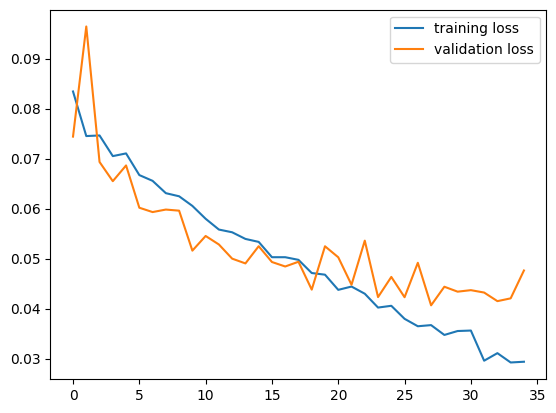

In [17]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

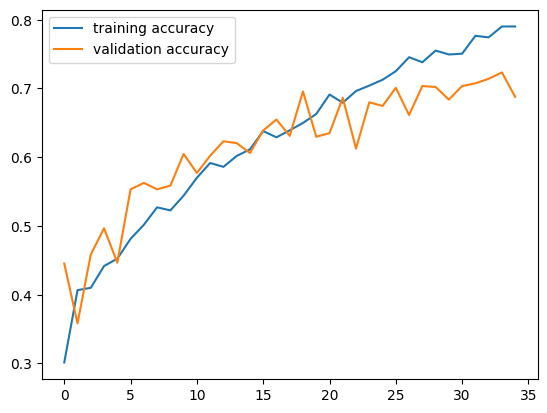

In [18]:
# Convert tensors to NumPy arrays and then to Python lists
running_corrects_history_list = [tensor.item() for tensor in running_corrects_history]
val_running_corrects_history_list = [tensor.item() for tensor in val_running_corrects_history]

# Plotting accuracy curves
plt.plot(running_corrects_history_list, label='training accuracy')
plt.plot(val_running_corrects_history_list, label='validation accuracy')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [20]:
# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_preds = []

for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[206  14  21  11  14  21]
 [  2 316  13   5  12   6]
 [  2  50 214  10   9   1]
 [  3  17  12 356   7   8]
 [  2  50  10  20 259   6]
 [  0  11   4   1   5  70]]

Precision for each class:
cardboard: 0.9581
glass: 0.6900
metal: 0.7810
paper: 0.8834
plastic: 0.8464
trash: 0.6250

Recall for each class:
cardboard: 0.7178
glass: 0.8927
metal: 0.7483
paper: 0.8834
plastic: 0.7464
trash: 0.7692


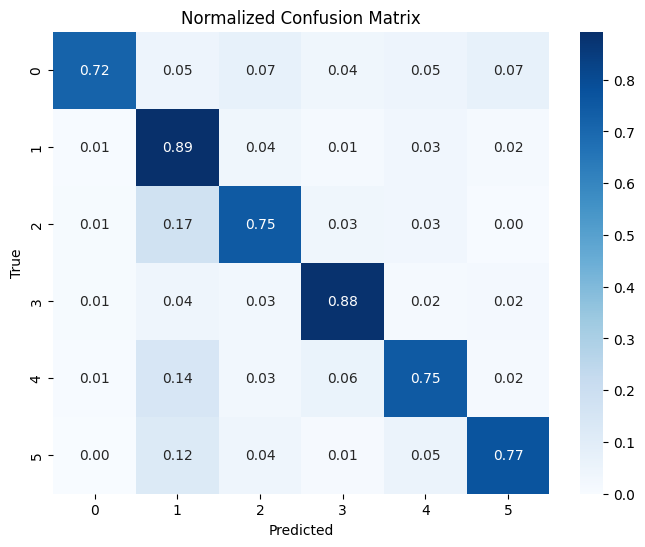

In [22]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
# Calculate overall precision
overall_precision = precision_score(all_labels, all_preds, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.8197


In [24]:
# Calculate overall recall
overall_recall = recall_score(all_labels, all_preds, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.8037
Overall F1 Score: 0.8052


In [25]:
# Initialize empty lists to store true labels and predicted labels
all_labels_t = []
all_preds_t = []

for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels_t.extend(labels.cpu().numpy())
    all_preds_t.extend(preds.cpu().numpy())

In [26]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels_t, all_preds_t)

# Calculate precision and recall for each class
precision = precision_score(all_labels_t, all_preds_t, average=None)
recall = recall_score(all_labels_t, all_preds_t, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[ 78   9   7   7   7   8]
 [  0 125   9   3   8   2]
 [  1  23  83   9   5   3]
 [  2  18   9 136  10  16]
 [  2  32  11   9  72   9]
 [  0  10   5   2   1  28]]

Precision for each class:
cardboard: 0.9398
glass: 0.5760
metal: 0.6694
paper: 0.8193
plastic: 0.6990
trash: 0.4242

Recall for each class:
cardboard: 0.6724
glass: 0.8503
metal: 0.6694
paper: 0.7120
plastic: 0.5333
trash: 0.6087


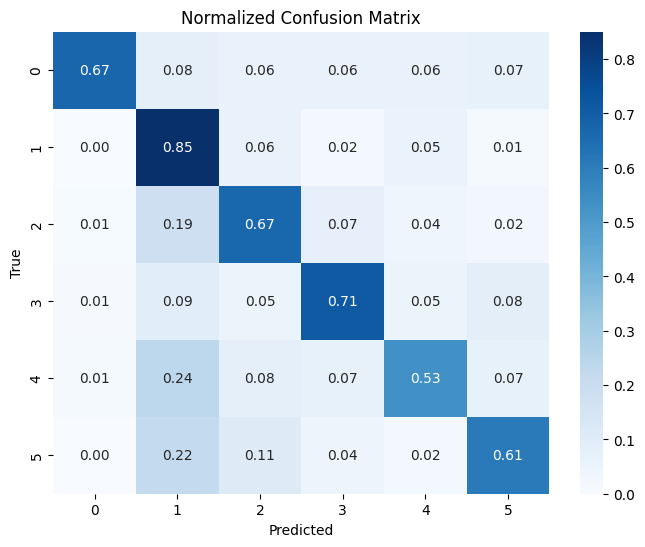

In [27]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels_t),
            yticklabels=np.unique(all_labels_t))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [28]:
# Calculate overall precision
overall_precision = precision_score(all_labels_t, all_preds_t, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.7208


In [29]:
# Calculate overall recall
overall_recall = recall_score(all_labels_t, all_preds_t, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels_t, all_preds_t, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.6877
Overall F1 Score: 0.6918
